<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/MeteoBale/MeteoBale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd


import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# Chargement des données

In [2]:
!rm *.zip
!rm *.csv
!wget --no-check-certificate --content-disposition "https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/MeteoBale.zip?raw=true"
!unzip MeteoBale.zip

rm: cannot remove '*.zip': No such file or directory
rm: cannot remove '*.csv': No such file or directory
--2021-05-21 16:17:19--  https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/MeteoBale.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/AlexandreBourrieau/ML/raw/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/MeteoBale.zip [following]
--2021-05-21 16:17:19--  https://github.com/AlexandreBourrieau/ML/raw/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/MeteoBale.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/MeteoBale.zip [following]
--2021-05-21 16:17:19--  https://raw.githubusercontent.c

In [3]:
# Création de la série sous Pandas
df_complet = pd.read_csv("MeteoBale.csv",delimiter=";",decimal=",")
df_complet

,timestamp,Bale Temperature [2 m elevation corrected],Bale Precipitation Total,Bale Relative Humidity [2 m],Bale Wind Speed [10 m],Bale Wind Direction [10 m],Bale Cloud Cover Total,Bale Sunshine Duration,Bale Shortwave Radiation,Bale Mean Sea Level Pressure [MSL]
0,2010-01-01T00:00:00,7.180529,0.0,83,5.692099,124.695150,100.0,0.0,0.0,993.1
1,2010-01-01T01:00:00,6.570528,0.0,86,6.618519,112.380135,100.0,0.0,0.0,993.1
2,2010-01-01T02:00:00,5.680529,0.0,92,7.072878,104.743550,100.0,0.0,0.0,992.6
3,2010-01-01T03:00:00,4.570528,0.0,95,7.862518,105.945400,99.0,0.0,0.0,992.1
4,2010-01-01T04:00:00,4.100529,0.0,94,7.172949,107.525570,82.0,0.0,0.0,991.2
...,...,...,...,...,...,...,...,...,...,...
96451,2021-01-01T19:00:00,1.970529,0.0,85,18.003600,358.854250,100.0,0.0,0.0,1007.9
96452,2021-01-01T20:00:00,1.730529,0.0,85,16.203999,358.727000,100.0,0.0,0.0,1008.0
96453,2021-01-01T21:00:00,1.520529,0.0,86,13.679999,360.000000,100.0,0.0,0.0,1008.1
96454,2021-01-01T22:00:00,1.120529,0.0,90,10.446206,358.025100,100.0,0.0,0.0,1008.4


In [ ]:
df_complet.dtypes

In [4]:
df_complet.iloc[:,1:] = df_complet.iloc[:,1:].astype(np.float32)
df_complet.index = pd.to_datetime(df_complet['timestamp'],yearfirst=True)
df_complet = df_complet.drop(columns=['timestamp'])
df_complet

,Bale Temperature [2 m elevation corrected],Bale Precipitation Total,Bale Relative Humidity [2 m],Bale Wind Speed [10 m],Bale Wind Direction [10 m],Bale Cloud Cover Total,Bale Sunshine Duration,Bale Shortwave Radiation,Bale Mean Sea Level Pressure [MSL]
timestamp,,,,,,,,,
2010-01-01 00:00:00,7.180529,0.0,83.0,5.692099,124.695152,100.0,0.0,0.0,993.099976
2010-01-01 01:00:00,6.570529,0.0,86.0,6.618519,112.380135,100.0,0.0,0.0,993.099976
2010-01-01 02:00:00,5.680529,0.0,92.0,7.072878,104.743553,100.0,0.0,0.0,992.599976
2010-01-01 03:00:00,4.570529,0.0,95.0,7.862518,105.945396,99.0,0.0,0.0,992.099976
2010-01-01 04:00:00,4.100529,0.0,94.0,7.172949,107.525574,82.0,0.0,0.0,991.200012
...,...,...,...,...,...,...,...,...,...
2021-01-01 19:00:00,1.970529,0.0,85.0,18.003599,358.854248,100.0,0.0,0.0,1007.900024
2021-01-01 20:00:00,1.730529,0.0,85.0,16.203999,358.726990,100.0,0.0,0.0,1008.000000
2021-01-01 21:00:00,1.520529,0.0,86.0,13.679999,360.000000,100.0,0.0,0.0,1008.099976


In [5]:
df_soleil = df_complet["Bale Shortwave Radiation"]
df_soleil

timestamp
2010-01-01 00:00:00    0.0
2010-01-01 01:00:00    0.0
2010-01-01 02:00:00    0.0
2010-01-01 03:00:00    0.0
2010-01-01 04:00:00    0.0
                      ... 
2021-01-01 19:00:00    0.0
2021-01-01 20:00:00    0.0
2021-01-01 21:00:00    0.0
2021-01-01 22:00:00    0.0
2021-01-01 23:00:00    0.0
Name: Bale Shortwave Radiation, Length: 96456, dtype: float32

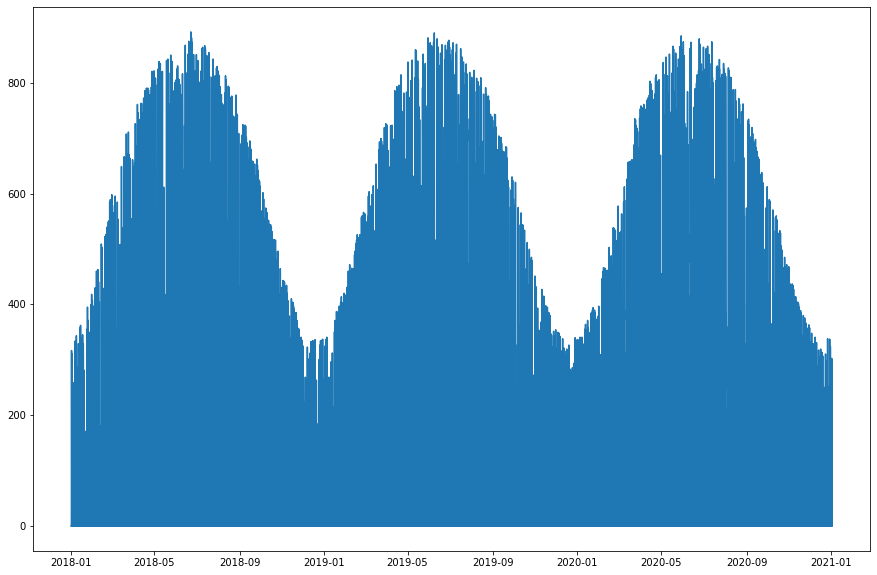

In [6]:
date_debut = "2018-01-01 00:00:00"
date_fin = "2021-01-01 23:00:00"

df_etude = df_soleil.loc[date_debut:date_fin]

f1, ax = plt.subplots(1, 1, figsize=(15, 10))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

ax.plot(df_etude.index, df_etude.values)


# Recherche et correction des données manquantes et des anomalies

**1. Recherche des données manquantes**

On commence par rechercher combien de données sont manquantes dans chaque colonne sur l'intervalle choisi :

In [ ]:
data_manquantes = sum(np.isnan(df_etude))
print ("Données manquantes : %s" %data_manquantes)


**2. Détection des anomalies**

Les anomalies sont fréquentes dans les séries temporelles, et la performance des prédictions est souvent améliorée lorsque ces anomalies sont traitées.  
Pour avoir un apperçu de ces éventuelles anomalies, nous allons utiliser la méthode ["Isolation Forest"](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest) disponnible dans Scikit-learn.  

Les paramètres utilisés sont les suivants :
 - **n_estimators** : C'est le nombre de sous-groupes d'échantillons à utiliser. Une valeur de 128 ou 256 est préconnisée dans le document de recherche.
 - **max_samples** : C'est le nombre d'échantillons maximum à utiliser. Nous utiliserons l'ensemble des échantillons.
 - **max_features** :  C'est le nombre de motifs aléatoirement choisis sur chaque noeud de l'arbre. Nous choisirons un seul motif.
 - **contamination** : C'est le pourcentage estimé d'anomalies dans les données. Ce paramètre permet de régler la sensibilité de l'algorithme. On va commencer avec 5% et affiner si nécessaire par la suite.

In [ ]:
# Initialise le modèle
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=256,max_samples=df_etude.size, contamination=0.01,max_features=1, verbose=1)
clf.fit(df_etude.values.reshape(-1,1))

In [ ]:
# Réalise les prédictions
pred = clf.predict(df_etude.values.reshape(-1,1))
pred

In [ ]:
np.count_nonzero(pred < 0)

In [ ]:
df_etude_ = pd.DataFrame(df_etude)

# Ajoute une colonne "Anomalie" dans la série
df_etude_['Anomalies'] = pred
df_etude_['Anomalies'] = df_etude_['Anomalies'].apply(lambda x: 1 if (x==-1) else 0)

# Affiche les informations sur les anomalies
print(df_etude_['Anomalies'].value_counts())

**3. Affichage des anomalies sur le graphique**

In [ ]:
# Affiche la série

fig = px.line(x=df_etude_.index,y=df_etude_['Bale Shortwave Radiation'])
fig.add_trace(px.scatter(x=df_etude_.index,y=df_etude_['Anomalies']*df_etude_['Bale Shortwave Radiation'],color=df_etude_['Anomalies'].astype(np.bool)).data[0])

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Analyse de la série

**1. ACF & PACF**

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Text(0.5, 1.0, 'Autocorrélation partielle')

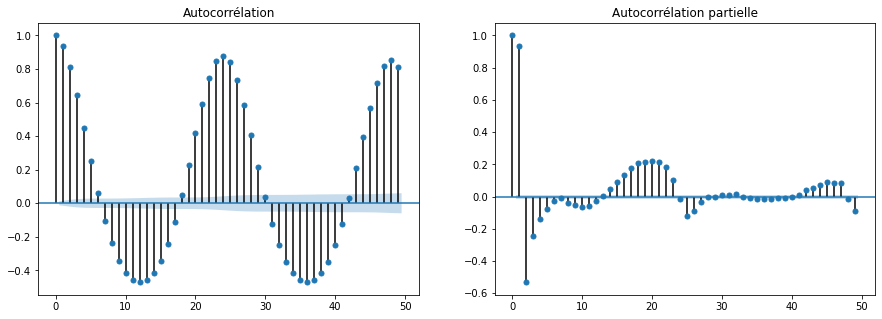

In [7]:
# ACF & PACF du bruit blanc

serie = df_etude

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation")

plot_pacf(serie, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle")

**2. Test de Dickey-Fuller**

In [8]:
import statsmodels.api as sm

serie_test = serie

adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -8.640302392335435
p-value: 5.448869793691578e-14,
N: 26278, 
critical values: {'1%': -3.4305988750628025, '5%': -2.8616499954783987, '10%': -2.5668285473360037}


# Préparation des datasets

**1. Séparation des données en données pour l'entrainement et la validation**

In [17]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(df_etude) * pourcentage)
date_separation = df_etude.index[temps_separation]

serie_entrainement = df_etude.iloc[:temps_separation]
serie_test = df_etude.iloc[temps_separation:]

print("Taille de l'entrainement : %d" %len(serie_entrainement))
print("Taille de la validation : %d" %len(serie_test))

Taille de l'entrainement : 21062
Taille de la validation : 5266


In [18]:
# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(np.asarray(serie_entrainement))
std = tf.math.reduce_std(np.asarray((serie_entrainement)))

# Normalisation des données
serie_entrainement = (serie_entrainement-mean)/std
serie_test = (serie_test-mean)/std

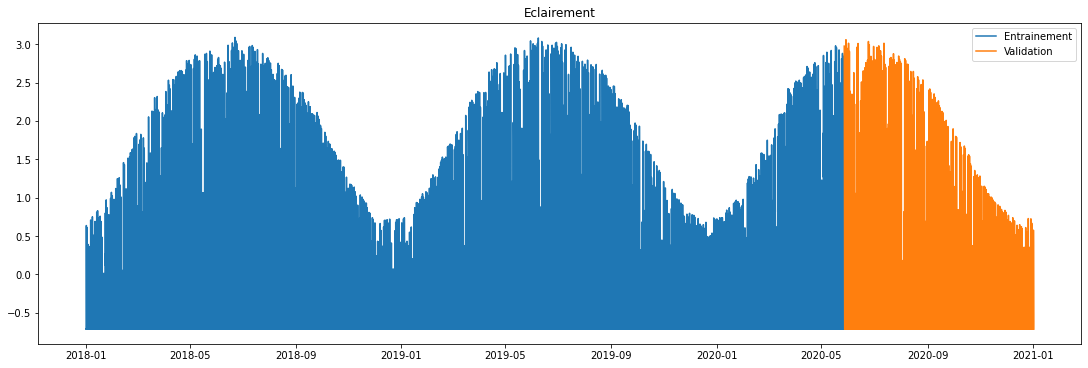

In [19]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))
ax.plot(serie_entrainement, label="Entrainement")
ax.plot(serie_test,label="Validation")

ax.set_title("Eclairement")

ax.legend()
plt.show()

**2. Création des datasets**

In [20]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle

def prepare_dataset_XY(serie, taille_fenetre, horizon, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+horizon, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + horizon))
  dataset = dataset.map(lambda x: (tf.expand_dims(x[0:taille_fenetre],axis=1),x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

In [21]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 40
horizon = 1
batch_size = 512

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement,taille_fenetre,horizon,batch_size)
dataset_val = prepare_dataset_XY(serie_test,taille_fenetre,horizon,batch_size)

In [22]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0].shape)
  print(element[1].shape)

41
(512, 40, 1)
(512, 1)


On extrait maintenant les deux tenseurs (X,Y) pour l'entrainement :

In [23]:
# Extrait les X,Y du dataset
#41x((512,40,1),(512,1)) => (41*512,40,1) ; (41*512,1)

x,y = tuple(zip(*dataset))

# Recombine les données
# (41,512,40,1) => (41*512,40,1)
# (41,512,1) => (41*512,1)
x_train = np.asarray(tf.reshape(np.asarray(x,dtype=np.float32),shape=(np.asarray(x).shape[0]*np.asarray(x).shape[1],taille_fenetre,1)))
y_train = np.asarray(tf.reshape(np.asarray(y,dtype=np.float32),shape=(np.asarray(y).shape[0]*np.asarray(y).shape[1])))

# Affiche les formats
print(x_train.shape)
print(y_train.shape)

(20992, 40, 1)
(20992,)


Puis la même chose pour les données de validation :

In [25]:
# Extrait les X,Y du dataset_val

x,y = tuple(zip(*dataset_val))

# Recombine les données

x_val = np.asarray(tf.reshape(np.asarray(x,dtype=np.float32),shape=(np.asarray(x).shape[0]*np.asarray(x).shape[1],taille_fenetre,1)))
y_val = np.asarray(tf.reshape(np.asarray(y,dtype=np.float32),shape=(np.asarray(y).shape[0]*np.asarray(y).shape[1])))

# Affiche les formats
print(x_val.shape)
print(y_val.shape)

(5120, 40, 1)
(5120,)


# Optimisation des hyperparamètres

**1. Création du réseau**

In [ ]:
def ModelLSTM(dim_LSTM = 10, l1_reg=0, l2_reg=0, lrate=1e-3, taille_fen = 10, bs=512):
  # Définition de l'entrée du modèle
  entrees = tf.keras.layers.Input(shape=(taille_fen,1))

  # Encodeur
  s_encodeur = tf.keras.layers.LSTM(dim_LSTM, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(entrees)

  # Décodeur
  s_decodeur = tf.keras.layers.Dense(dim_LSTM,activation="tanh",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(s_encodeur)
  s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

  # Générateur
  sortie = tf.keras.layers.Dense(1,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(s_decodeur)

  # Définition de l'optimiseur à utiliser
  optimiseur=tf.keras.optimizers.SGD(lr = lrate, momentum=0.9)

  # Construction du modèle
  model = tf.keras.Model(entrees,sortie)
  model.compile(loss='mse', optimizer=optimiseur)
  return(model)

**2. Optimisation de l'apprentissage**

Pour accélérer le traitement des données, nous n'allons pas utiliser l'intégralité des données pendant la mise à jour du gradient, comme cela a été fait jusqu'à présent (en utilisant le dataset).  
Cette fois-ci, nous allons forcer les mises à jour du gradient à se produire de manière moins fréquente en attribuant la valeur du batch_size à prendre en compte lors de la regression du modèle.  
Pour cela, on utilise l'argument "batch_size" dans la méthode fit. En précisant un batch_size=1000, cela signifie que :
 - Sur notre total de 56000 échantillons, 56 seront utilisés pour les calculs du gradient
 - Il y aura également 56 itérations à chaque période.
  
    
    
Si nous avions pris le dataset comme entrée, nous aurions eu :
- Un total de 56000 échantillons également
- Chaque période aurait également pris 56 itérations pour se compléter
- Mais 1000 échantillons auraient été utilisés pour le calcul du gradient, au lieu de 56 avec la méthode utilisée.

In [ ]:
model = ModelLSTM(dim_LSTM=32,lrate=1e-3,taille_fen=10)

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD()

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(x=x_train,y=y_train,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=batch_size)

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[20], taux[99], 0, 1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

**3. Cross-Validation**

In [ ]:
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV
import pickle
from google.colab import files

# Définitions des paramètres
dim_LSTM = [16,32,64,128]
l1_reg = [0,0.001,0.01,0.1]
l2_reg = [0,0.001,0.01,0.1]
taille_fen = [7,10,15,30,50]
batch_s = [512]
lrate = [0.1]

max_periodes = 1

# Surveillance de l'entrainement
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20, min_delta=1e-4, restore_best_weights=True)
tscv = TimeSeriesSplit(n_splits = 5)

grid_result = []
for bsize in bs:
  for taille in taille_fen:
    param_grid = {'dim_LSTM': dim_LSTM, 'l1_reg': l1_reg, 'l2_reg': l2_reg, 'lrate': lrate, 'taille_fen': [taille], 'bs':[bsize]}

    dataset = prepare_dataset_XY(serie_entrainement,taille,horizon,bsize)

    x,y = tuple(zip(*dataset))
    x_train = np.asarray(tf.reshape(np.asarray(x,dtype=np.float32),shape=(np.asarray(x).shape[0]*np.asarray(x).shape[1],taille,1)))
    y_train = np.asarray(tf.reshape(np.asarray(y,dtype=np.float32),shape=(np.asarray(y).shape[0]*np.asarray(y).shape[1])))

    model = KerasRegressor(build_fn=ModelLSTM, epochs=max_periodes, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, n_jobs=1, verbose=3)

    res = grid.fit(x_train, y_train,callbacks=[es])
    grid_result.append(res)

print(grid_result)
for gres in grid_result:
  print("============")
  print(gres.best_params_)
  print(gres.best_score_)

In [ ]:
print(grid_result)
for gres in grid_result:
  print("============")
  print(gres.best_params_)
  print(gres.best_score_)

Voici les résultats obtenus :  

{'bs': 512, 'dim_LSTM': 64, 'l1_reg': 0, 'l2_reg': 0, 'lrate': 0.1,'taille_fen': 7}
-0.05640198327600956

{'bs': 512, 'dim_LSTM': 64, 'l1_reg': 0, 'l2_reg': 0, 'lrate': 0.1, 'taille_fen': 15}
-0.05461240783333778

{'bs': 512, 'dim_LSTM': 128, 'l1_reg': 0, 'l2_reg': 0, 'lrate': 0.1, 'taille_fen': 20}
-0.05034010596573353

**{'bs': 512, 'dim_LSTM': 128, 'l1_reg': 0, 'l2_reg': 0, 'lrate': 0.1, 'taille_fen': 40}**
**-0.04946720190346241**

{'bs': 512, 'dim_LSTM': 32, 'l1_reg': 0, 'l2_reg': 0, 'lrate': 0.1, 'taille_fen': 60}
-0.05386147387325764



# Création du modèle LSTM de type encodeur-décodeur

**1. Création du réseau**

Par défaut, la dimension des vecteurs cachés est de 10 et aucune régularisation n'est utilisée.

In [29]:
dim_LSTM = 128
l1_reg = 0.0
l2_reg = 0.0

# Définition de l'entrée du modèle
entrees = tf.keras.layers.Input(shape=(taille_fenetre,1))

# Encodeur
s_encodeur = tf.keras.layers.LSTM(dim_LSTM, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(entrees)

# Décodeur
s_decodeur = tf.keras.layers.Dense(dim_LSTM,activation="tanh",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(s_encodeur)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

# Générateur
sortie = tf.keras.layers.Dense(1,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(s_decodeur)

# Construction du modèle
model = tf.keras.Model(entrees,sortie)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40, 1)]      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          66560       input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          16512       lstm_1[0][0]                     
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256)          0           dense_2[0][0]                    
                                                                 lstm_1[0][0]               

**2. Optimisation de l'apprentissage**

Pour accélérer le traitement des données, nous n'allons pas utiliser l'intégralité des données pendant la mise à jour du gradient, comme cela a été fait jusqu'à présent (en utilisant le dataset).  
Cette fois-ci, nous allons forcer les mises à jour du gradient à se produire de manière moins fréquente en attribuant la valeur du batch_size à prendre en compte lors de la regression du modèle.  
Pour cela, on utilise l'argument "batch_size" dans la méthode fit. En précisant un batch_size=4096, cela signifie que :
 - Sur notre total de 20992 échantillons, 20992/4096=11 seront utilisés pour les calculs du gradient
 - Il y aura également 11 itérations à chaque période.
  
    
    
Si nous avions pris le dataset comme entrée, nous aurions eu :
- Un total de 20992 échantillons également
- Chaque période aurait également pris 11 itérations pour se compléter
- Mais 512 échantillons auraient été utilisés pour le calcul du gradient, au lieu de 11 avec la méthode utilisée.

In [35]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD()

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(x=x_train,y=y_train,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=batch_size)

Epoch 1/100
41/41 [==============================] - 11s 239ms/step - loss: 1.0987 - mse: 1.0987

Epoch 00001: loss improved from inf to 1.10878, saving model to poids.hdf5
Epoch 2/100
41/41 [==============================] - 10s 242ms/step - loss: 1.1055 - mse: 1.1055

Epoch 00002: loss improved from 1.10878 to 1.10878, saving model to poids.hdf5
Epoch 3/100
41/41 [==============================] - 10s 245ms/step - loss: 1.1223 - mse: 1.1223

Epoch 00003: loss improved from 1.10878 to 1.10878, saving model to poids.hdf5
Epoch 4/100
41/41 [==============================] - 10s 242ms/step - loss: 1.1076 - mse: 1.1076

Epoch 00004: loss improved from 1.10878 to 1.10878, saving model to poids.hdf5
Epoch 5/100
41/41 [==============================] - 10s 246ms/step - loss: 1.1194 - mse: 1.1194

Epoch 00005: loss improved from 1.10878 to 1.10878, saving model to poids.hdf5
Epoch 6/100
41/41 [==============================] - 10s 242ms/step - loss: 1.1340 - mse: 1.1340

Epoch 00006: loss imp

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

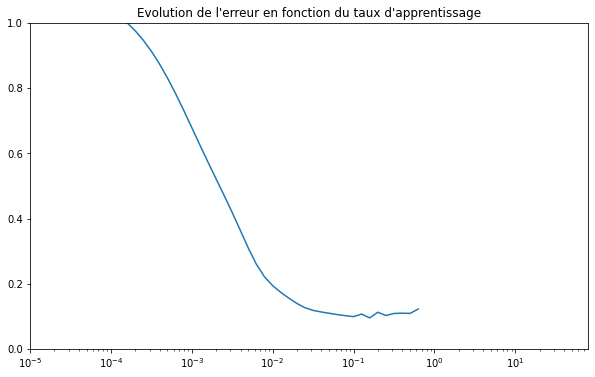

In [37]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[30], taux[99], 0, 1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [38]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [39]:
max_periodes = 500

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

 
# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.2,
    decay_steps=10,
    decay_rate=0.01)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

# Entraine le modèle, avec une réduction des calculs du gradient
#historique = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-4,periodes = 10, term="loss")],batch_size=batch_size)

# Entraine le modèle sans réduction de calculs
historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-5,periodes = 10, term="loss")])


Epoch 1/500
41/41 [==============================] - 14s 319ms/step - loss: 0.1083 - mse: 0.1083 - val_loss: 0.1138 - val_mse: 0.1138

Epoch 00001: loss improved from inf to 0.11761, saving model to poids_train.hdf5
Epoch 2/500
41/41 [==============================] - 13s 307ms/step - loss: 0.1330 - mse: 0.1330 - val_loss: 0.1755 - val_mse: 0.1755

Epoch 00002: loss improved from 0.11761 to 0.11040, saving model to poids_train.hdf5
Epoch 3/500
41/41 [==============================] - 13s 311ms/step - loss: 0.1234 - mse: 0.1234 - val_loss: 0.1187 - val_mse: 0.1187

Epoch 00003: loss improved from 0.11040 to 0.10895, saving model to poids_train.hdf5
Epoch 4/500
41/41 [==============================] - 13s 308ms/step - loss: 0.1068 - mse: 0.1068 - val_loss: 0.1104 - val_mse: 0.1104

Epoch 00004: loss improved from 0.10895 to 0.09648, saving model to poids_train.hdf5
Epoch 5/500
41/41 [==============================] - 13s 310ms/step - loss: 0.1128 - mse: 0.1128 - val_loss: 0.1345 - val_ms

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

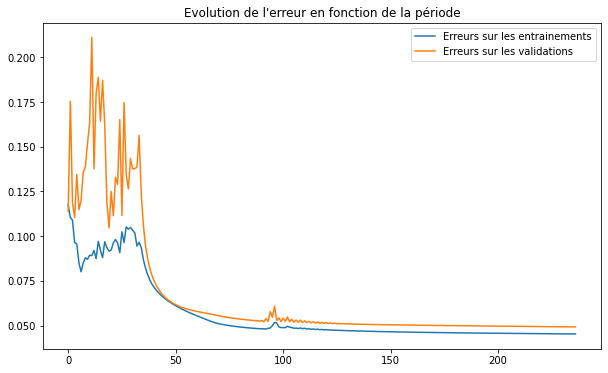

In [40]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Enregistre les poids du modèle :

In [ ]:
from google.colab import files

files.download('poids_train.hdf5') 

Charge les poids du modèle :

In [ ]:
!wget --no-check-certificate --content-disposition "https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/MeteoBale/poids_train_LSTM_Meteo.hdf5?raw=true"

In [42]:
model.load_weights("poids_train_LSTM_Meteo.hdf5")

In [ ]:
# Evaluation du modèle
model.evaluate(dataset)
model.evaluate(dataset_val)


#Prédictions

In [43]:
# Création des instants d'entrainement et de validation
y_train_timing = serie_entrainement.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_train)]
y_val_timing = serie_test.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_val)]

# Calcul des prédictions
pred_ent = model.predict(dataset)
pred_val = model.predict(dataset_val)

In [44]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
serie = np.concatenate([serie_entrainement,serie_test])
index = np.linspace(0,len(serie)-1,len(serie),dtype=np.int16)
fig.add_trace(go.Scatter(x=index,y=serie,line=dict(color='blue', width=1),name="Série oroginale"))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=index[taille_fenetre:],y=pred_ent[:,0],line=dict(color='green', width=1),name="Entrainement"))

# Courbe de validation
fig.add_trace(go.Scatter(x=index[temps_separation+taille_fenetre:],y=pred_val[:,0],line=dict(color='red', width=1),name="Validation"))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Création du modèle LSTM avec CNN


**1. Création du réseau**

In [50]:
dim_LSTM = 128

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)


# Définition de l'entrée du modèle
entrees = tf.keras.layers.Input(shape=(taille_fenetre))

# Encodeur
e_adapt = tf.keras.layers.Lambda(Traitement_Entrees)(entrees)
e_cnn = tf.keras.layers.Conv1D(filters=dim_LSTM,kernel_size=3, strides=1, padding="causal", activation="relu")(e_adapt)
e_cnn = tf.keras.layers.Dropout(0.0)(e_cnn)
s_encodeur = tf.keras.layers.LSTM(dim_LSTM)(e_cnn)

# Décodeur
s_decodeur = tf.keras.layers.Dense(dim_LSTM,activation="tanh")(s_encodeur)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

# Générateur
sortie = tf.keras.layers.Dense(1)(s_decodeur)

# Construction du modèle
model = tf.keras.Model(entrees,sortie)

model.save_weights("model_initial.hdf5")
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 40, 1)        0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 40, 128)      512         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 40, 128)      0           conv1d_2[0][0]                   
____________________________________________________________________________________________

**2. Optimisation de l'apprentissage**

In [51]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(x=x_train,y=y_train,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=batch_size)

Epoch 1/100
41/41 [==============================] - 16s 350ms/step - loss: 1.0461 - mse: 1.0461

Epoch 00001: loss improved from inf to 1.05212, saving model to poids.hdf5
Epoch 2/100
41/41 [==============================] - 14s 352ms/step - loss: 1.0391 - mse: 1.0391

Epoch 00002: loss improved from 1.05212 to 1.05206, saving model to poids.hdf5
Epoch 3/100
41/41 [==============================] - 14s 353ms/step - loss: 1.0375 - mse: 1.0375

Epoch 00003: loss improved from 1.05206 to 1.05198, saving model to poids.hdf5
Epoch 4/100
41/41 [==============================] - 14s 348ms/step - loss: 1.0549 - mse: 1.0549

Epoch 00004: loss improved from 1.05198 to 1.05189, saving model to poids.hdf5
Epoch 5/100
41/41 [==============================] - 14s 349ms/step - loss: 1.0317 - mse: 1.0317

Epoch 00005: loss improved from 1.05189 to 1.05176, saving model to poids.hdf5
Epoch 6/100
41/41 [==============================] - 14s 346ms/step - loss: 1.0503 - mse: 1.0503

Epoch 00006: loss imp

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

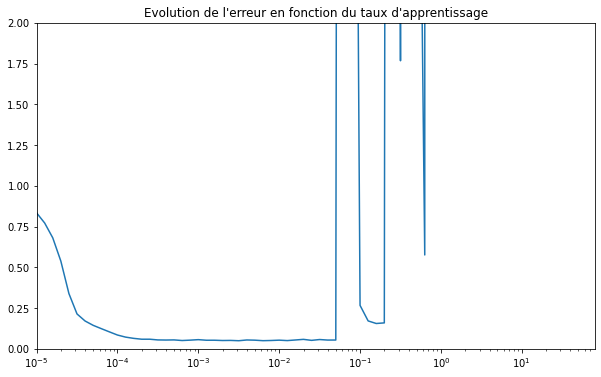

In [52]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[30], taux[99], 0, 2])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [53]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [54]:
max_periodes = 1000

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

def  My_MSE(y_true,y_pred):
  return(tf.keras.metrics.mse(y_true,y_pred)*std.numpy()+mean.numpy())
  
# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.002,
    decay_steps=10,
    decay_rate=0.01)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

# Entraine le modèle, avec une réduction des calculs du gradient
#historique = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-5,periodes = 10, term="loss")],batch_size=batch_size)

# Entraine le modèle sans réduction de calculs
historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-5,periodes = 10, term="loss")],batch_size=batch_size)


Epoch 1/1000
41/41 [==============================] - 30s 705ms/step - loss: 0.1865 - mse: 0.1865 - val_loss: 0.1473 - val_mse: 0.1473

Epoch 00001: loss improved from inf to 0.18173, saving model to poids_train.hdf5
Epoch 2/1000
41/41 [==============================] - 29s 710ms/step - loss: 0.1163 - mse: 0.1163 - val_loss: 0.0825 - val_mse: 0.0825

Epoch 00002: loss improved from 0.18173 to 0.10124, saving model to poids_train.hdf5
Epoch 3/1000
41/41 [==============================] - 26s 635ms/step - loss: 0.0742 - mse: 0.0742 - val_loss: 0.0662 - val_mse: 0.0662

Epoch 00003: loss improved from 0.10124 to 0.06928, saving model to poids_train.hdf5
Epoch 4/1000
41/41 [==============================] - 28s 692ms/step - loss: 0.0640 - mse: 0.0640 - val_loss: 0.0605 - val_mse: 0.0605

Epoch 00004: loss improved from 0.06928 to 0.05994, saving model to poids_train.hdf5
Epoch 5/1000
41/41 [==============================] - 29s 704ms/step - loss: 0.0584 - mse: 0.0584 - val_loss: 0.0701 - v

Enregistre les poids du modèle :

In [55]:
from google.colab import files

files.download('poids_train.hdf5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
model.load_weights('poids_train.hdf5')

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

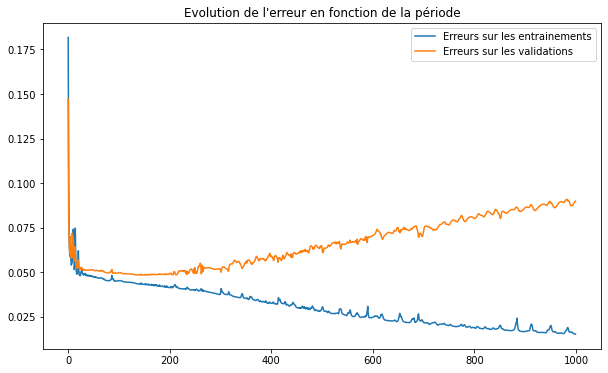

In [57]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
# Evaluation du modèle

model.evaluate(dataset)
model.evaluate(dataset_val)


**3. Prédictions**

In [58]:
# Création des instants d'entrainement et de validation
y_train_timing = serie_entrainement.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_train)]
y_val_timing = serie_test.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_val)]

# Calcul des prédictions
pred_ent = model.predict(dataset)
pred_val = model.predict(dataset_val)

In [59]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
serie = np.concatenate([serie_entrainement,serie_test])
index = np.linspace(0,len(serie)-1,len(serie),dtype=np.int16)
fig.add_trace(go.Scatter(x=index,y=serie,line=dict(color='blue', width=1),name="Série oroginale"))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=index[taille_fenetre:],y=pred_ent[:,0],line=dict(color='green', width=1),name="Entrainement"))

# Courbe de validation
fig.add_trace(go.Scatter(x=index[temps_separation+taille_fenetre:],y=pred_val[:,0],line=dict(color='red', width=1),name="Validation"))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()